In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm  

# Imposta il seed per numeri random per riproducibilità
np.random.seed(2024)

# Importa dati
data_prezzi: pd.DataFrame = pd.read_excel(r"prezzi_chiusura_unificati.xlsx", index_col="Date")

# Seleziona il periodo di interesse
inizio_periodo = "2017-11-24"
fine_periodo = "2024-07-31"
data_prezzi = data_prezzi.loc[inizio_periodo:fine_periodo]

# Rinomina le colonne per semplificare il codice
data_prezzi = data_prezzi.rename(columns={
    'IE00B5BMR087 CORE S&P 500 USD (ACC) IN EUR': 'SP500',
    'LU0908500753 EUROPE 600 UCITS ETF ACC IN EUR': 'EUROPA600',
    'IE00B4L5Y983 CORE MSCI WORLD USD (ACC) IN USD': 'MSCI WORLD USD',
    'IE000KCS7J59 MSCI EMERGING MARKETS USD (ACC) IN USD': 'EMERGING USD',
    'SGLD': 'GOLD USD',
    'EURUSD': 'EURUSD'
})

# Conversione degli strumenti in USD a EUR
data_prezzi['MSCI WORLD'] = data_prezzi['MSCI WORLD USD'] / data_prezzi['EURUSD']
data_prezzi['EMERGING'] = data_prezzi['EMERGING USD'] / data_prezzi['EURUSD']
data_prezzi['GOLD'] = data_prezzi['GOLD USD'] / data_prezzi['EURUSD']
data_prezzi['GOLDETF'] = data_prezzi['GOLDETF USD'] / data_prezzi['EURUSD']
data_prezzi['ACWI'] = data_prezzi['ACWI USD'] / data_prezzi['EURUSD']

# Rimozione delle colonne non necessarie
data = data_prezzi.drop(columns=['MSCI WORLD USD','EMERGING', 'EMERGING USD', 'GOLD USD', 'EURUSD', 'GOLDETF USD', 'ACWI USD'])



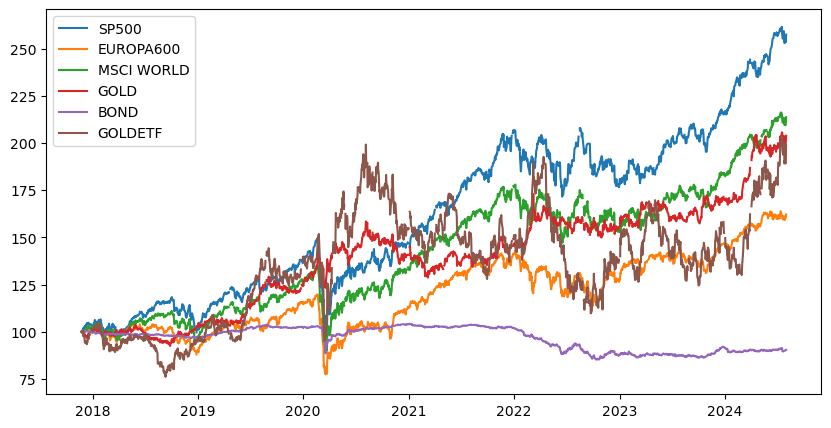

In [4]:
data_norm = pd.DataFrame()
risk_free_rate = 0.0375  # Tasso risk-free
indices = ['SP500', 'EUROPA600', 'MSCI WORLD', 'GOLD', 'BOND', 'GOLDETF' ]
for index in indices:
        data_norm[index] = (data[index] / data[index].iloc[0]) * 100

plt.figure(figsize=(10, 5))
plt.plot(data_norm, label = data_norm.columns)
plt.legend()
plt.show()

data_norm['Risk-Free'] = risk_free_rate/360
data_norm['Capital_risk_free'] = 100 * (1 + data_norm['Risk-Free']).cumprod()

In [3]:
# Calcolo dei rendimenti logaritmici
df = np.log(data).diff().dropna()

# Aggiungi l'asset risk-free
risk_free_rate = 0.0375  # Tasso risk-free
df['Risk-Free'] = risk_free_rate/260

# Calcolo dell'indice di mercato ponderato
weights_market = {
    'Equity': 0.4,
    'Fixed_Income': 0.5,
    'Commodities': 0.1
}

df['MARKET_INDEX'] = (weights_market['Equity'] * df['ACWI'] +
                      weights_market['Fixed_Income'] * df['OBBL'] +
                      weights_market['Commodities'] * df['COM'])

df = df.drop(columns=['COM', 'OBBL', 'ACWI'])
df_max_vol = df   
dfSR = df.drop(columns=['MARKET_INDEX'])


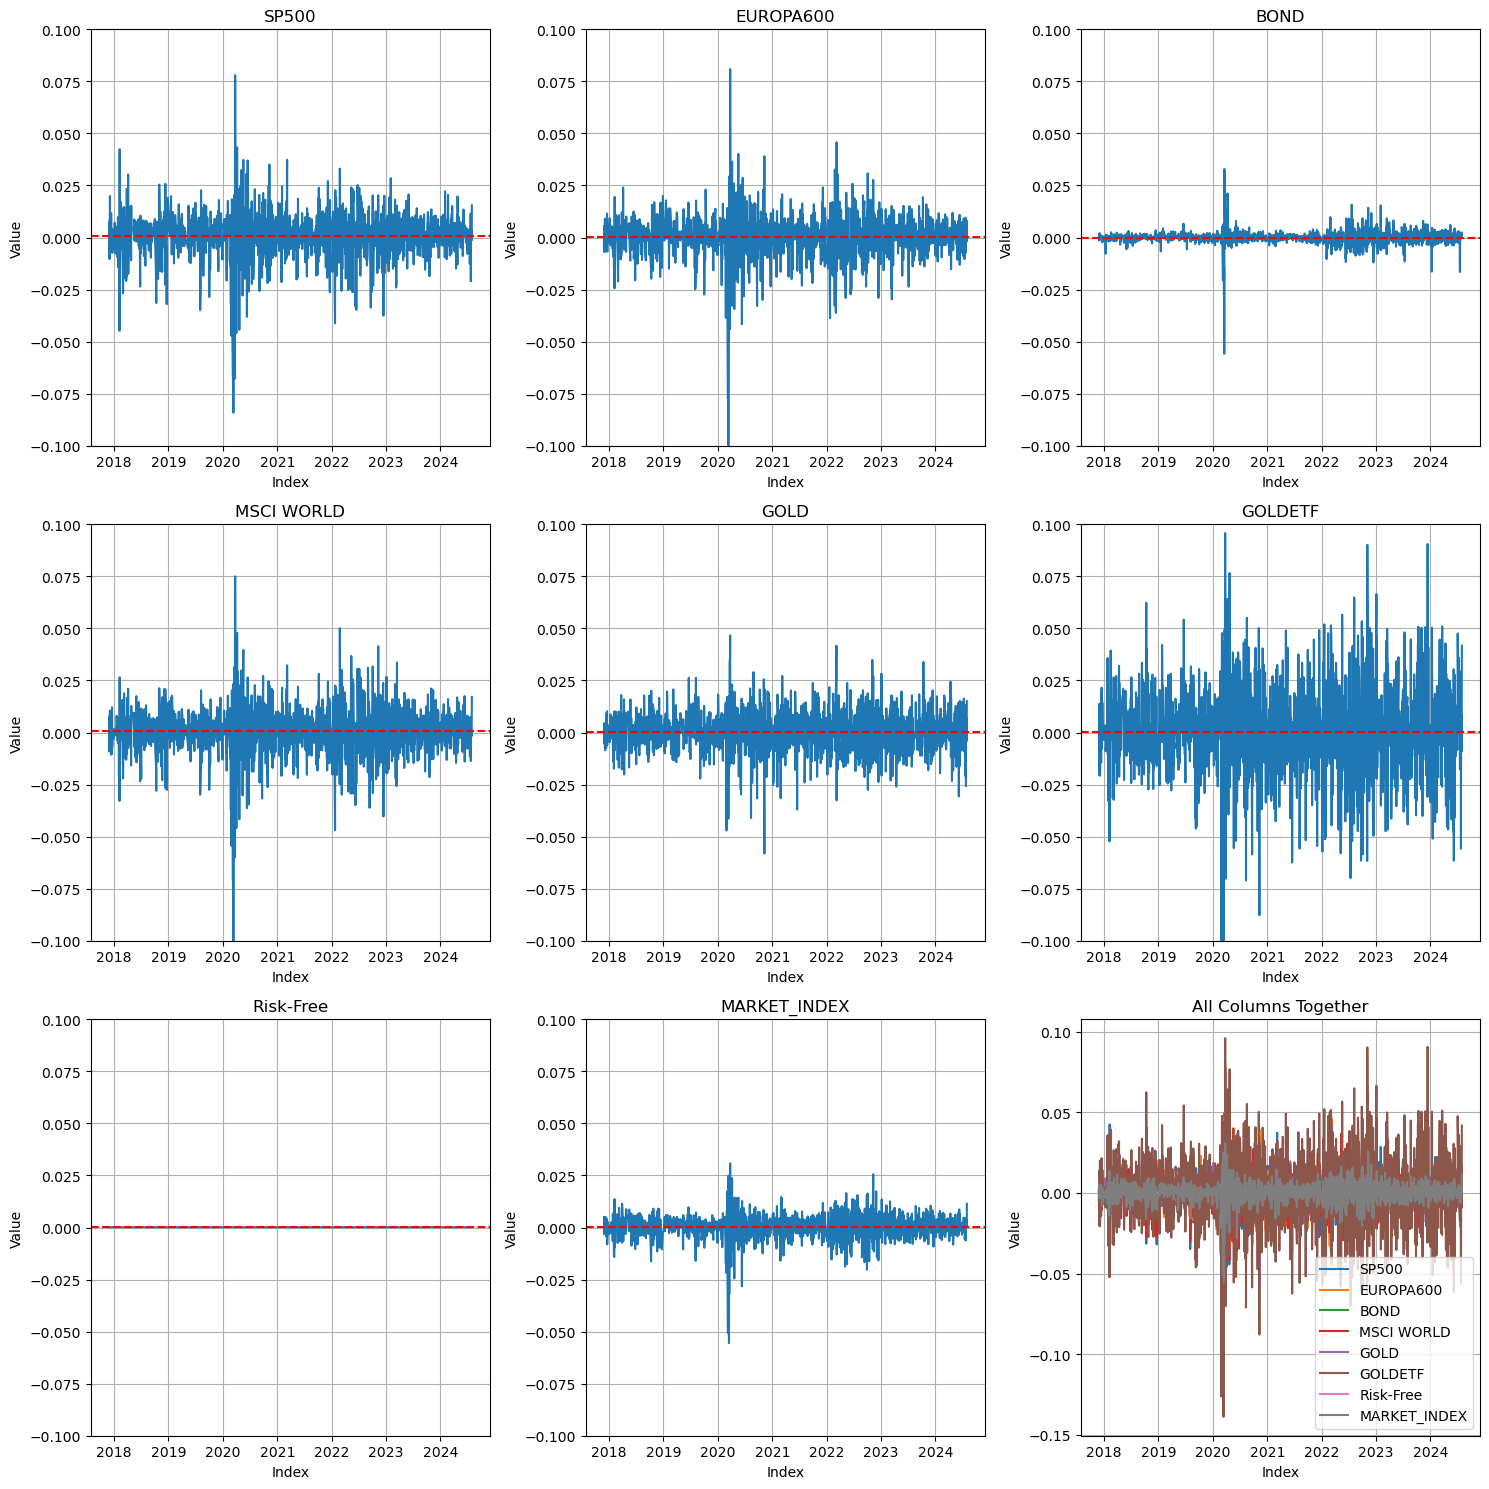

In [4]:
# Numero di colonne e righe per la griglia
num_cols = len(df.columns)
num_rows = (num_cols // 3) + 1  # Calcola il numero di righe necessarie

# Crea una figura e un array di subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows))

# Flatten l'array di axes per facilitare l'indicizzazione
axes = axes.flatten()

# Grafico per ogni colonna
for i, col in enumerate(df.columns):
    ax = axes[i]
    ax.plot(df.index, df[col])
    ax.axhline(y= df[col].dropna().mean(), color='r', linestyle='--')
    ax.set_title(col)
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    # Impostare i limiti fissi per l'asse x e y
    ax.set_ylim(-0.1, 0.1)  # Limiti dell'asse y
    ax.grid(True)

# Grafico per tutte le colonne insieme
ax = axes[num_cols]
for col in df.columns:
    ax.plot(df.index, df[col], label=col)
    ax.set_title('All Columns Together')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

# Nascondi gli assi non utilizzati (se ce ne sono)
for j in range(num_cols + 1, len(axes)):
    axes[j].axis('off')

# Mostra i grafici
plt.tight_layout()
plt.show()


In [5]:
sp500 = df['SP500'].dropna()
europa600 = df['EUROPA600'].dropna()
msci_world = df['MSCI WORLD'].dropna()
gold = df['GOLD'].dropna()
bond = df['BOND'].dropna()
goldetf = df['GOLDETF'].dropna()
mrk = df['MARKET_INDEX'].dropna()
risk_free = risk_free_rate
indices = ['SP500', 'EUROPA600', 'MSCI WORLD', 'GOLD', 'BOND', 'GOLDETF', 'MARKET_INDEX']
for index in indices:
    print(f"{index}\tMean: {df[index].mean()*260:.10f}\tStd: {df[index].std()*np.sqrt(260): 10f}")


SP500	Mean: 0.1649618776	Std:   0.178139
EUROPA600	Mean: 0.0888777828	Std:   0.171384
MSCI WORLD	Mean: 0.1329714535	Std:   0.190240
GOLD	Mean: 0.0873562858	Std:   0.156216
BOND	Mean: -0.0109571335	Std:   0.055801
GOLDETF	Mean: 0.0648484543	Std:   0.352928
MARKET_INDEX	Mean: 0.0506748010	Std:   0.096435


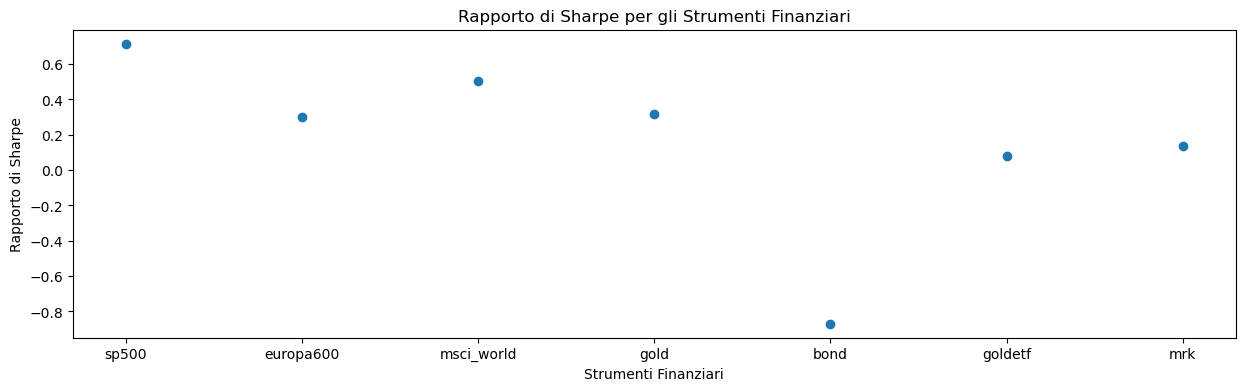

In [6]:
def SR(indice, rf):
    media = indice.mean() *260 
    std = indice.std() * np.sqrt(260)
    sr = (media - rf)/std
    return sr 

sharpe_sp500 = SR(sp500, risk_free)
sharpe_europa600 = SR(europa600, risk_free)
sharpe_msci_world = SR(msci_world, risk_free)
sharpe_mki = SR(mrk, risk_free)
sharpe_gold = SR(gold, risk_free)
sharpe_bond = SR(bond, risk_free)
sharpe_goldetf = SR(goldetf, risk_free)

instruments = ['sp500', 'europa600', 'msci_world', 'gold', 'bond', 'goldetf', 'mrk' ]
sharpe_ratios = [sharpe_sp500, sharpe_europa600, sharpe_msci_world, sharpe_gold, sharpe_bond, sharpe_goldetf, sharpe_mki]

# Creazione del grafico a barre
plt.figure(figsize=(15, 4))
plt.scatter(instruments, sharpe_ratios)
plt.xlabel('Strumenti Finanziari')
plt.ylabel('Rapporto di Sharpe')
plt.title('Rapporto di Sharpe per gli Strumenti Finanziari')
plt.show()

## Value at Risk (VaR)

Definizione: Il VaR è una misura statistica che stima la perdita massima potenziale di un portafoglio o di un investimento in un determinato periodo di tempo, con un certo livello di confidenza (ad esempio, il 95% o il 99%). In altre parole, indica la perdita che non dovrebbe essere superata, salvo eventi estremi.
Significato nella gestione del rischio: Il VaR viene utilizzato per quantificare l'esposizione al rischio di mercato di un portafoglio. Aiuta a determinare la quantità di capitale che un'istituzione finanziaria deve detenere per coprire potenziali perdite. Inoltre, il VaR è uno strumento utile per confrontare il rischio di diversi portafogli o strategie di investimento.

## Expected Shortfall (ES)

Definizione: L'ES, noto anche come Conditional Value at Risk (CVaR), misura la perdita media attesa nel caso in cui il VaR venga superato. In pratica, indica la gravità delle perdite che potrebbero verificarsi in scenari estremi.
Significato nella gestione del rischio: L'ES fornisce una visione più completa del rischio di coda rispetto al VaR, poiché considera non solo la probabilità di superare una certa soglia di perdita, ma anche l'entità delle perdite oltre tale soglia. Pertanto, l'ES è uno strumento importante per valutare il rischio di eventi estremi e per determinare il capitale necessario per far fronte a tali perdite.

## Beta

Il Beta misura la sensibilità del rendimento di un portafoglio rispetto al rendimento di un benchmark di mercato. Un Beta di 1 indica che il portafoglio tende a muoversi in linea con il mercato. Un Beta maggiore di 1 indica che il portafoglio è più volatile del mercato, amplificando i suoi movimenti sia al rialzo che al ribasso. Un Beta minore di 1 indica che il portafoglio è meno volatile del mercato, attenuando i suoi movimenti. Un Beta negativo indica che il portafoglio tende a muoversi in direzione opposta al mercato.

Utilità: Il Beta è un indicatore chiave per valutare il rischio sistematico di un portafoglio, ovvero il rischio legato all'andamento generale del mercato. Può essere utilizzato per costruire portafogli con diversi profili di rischio, a seconda della tolleranza dell'investitore.

## Alpha

L'Alpha misura il rendimento in eccesso (o in difetto) di un portafoglio rispetto al rendimento atteso, dato il suo livello di rischio (misurato dal Beta). Un Alpha positivo indica che il portafoglio ha sovraperformato il mercato, generando un rendimento superiore a quello atteso dato il suo Beta. Un Alpha negativo indica che il portafoglio ha sottoperformato il mercato.
Un Alpha di zero indica che il portafoglio ha generato un rendimento in linea con le aspettative, dato il suo Beta.

Utilità: L'Alpha è un indicatore chiave per valutare l'abilità del gestore del portafoglio nel generare rendimenti superiori al mercato, al netto del rischio assunto. Un Alpha positivo persistente nel tempo è un segnale di una buona gestione attiva del portafoglio.
Relazione tra Beta e Alpha

In [8]:
#df = df.drop(columns=[ 'MSCI WORLD', 'BOND', 'EUROPA600'])
df = df.drop(columns=['GOLDETF', 'MSCI WORLD', 'BOND', 'EUROPA600'])
data_norm = data_norm.drop(columns=['GOLDETF', 'MSCI WORLD', 'BOND', 'EUROPA600'])
df_max_vol = df   
dfSR = df.drop(columns=['MARKET_INDEX'])

Massimo Sharpe Ratio: 0.7981
Rendimento annuale del portafoglio: 0.123717
Volatilità annuale del portafoglio: 0.1080
VaR annuale a 5.0%: 0.1593
Expected Shortfall annuale a 5.0%: 0.2608
------------------------------------------------------
Pesi del portafoglio:
SP500 : 55.64%
GOLD : 30.67%
Risk-Free : 13.68%
------------------------------------------------------
Beta del portafoglio: 0.6973
Alpha del portafoglio: 8.83%


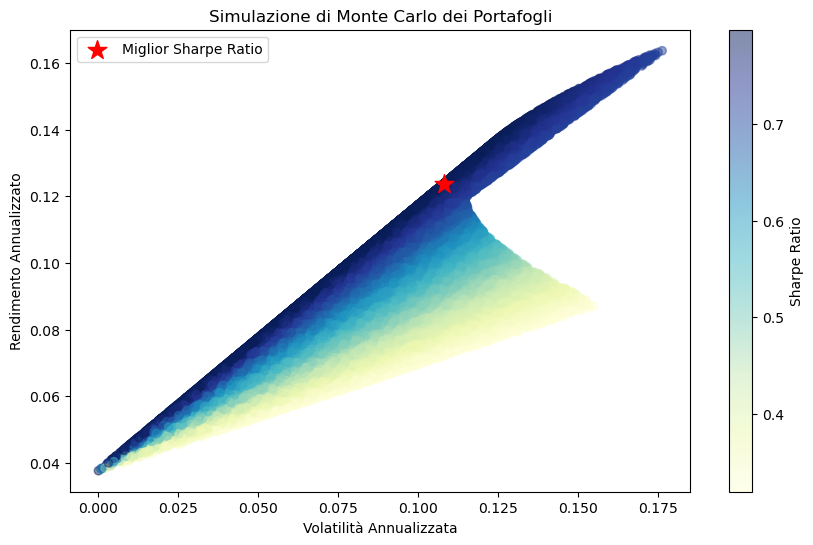

In [9]:
# Simulazione Monte Carlo per trovare il miglior portafoglio
mean_returns = dfSR.mean()
cov_matrix = dfSR.cov()
num_portfolios = 100000  # Numero di portafogli simulati
trading_days = 260  # Numero di giorni di trading nell'anno
alpha = 0.05  # Livello di confidenza per il VaR ed ES

# Array per i risultati
results = np.zeros((num_portfolios, 5))
weights_record = []

# Loop per la simulazione Monte Carlo
for i in range(num_portfolios):
    # Genera pesi casuali
    weights = np.random.random(len(dfSR.columns))
    weights /= np.sum(weights)
    
    # Calcola il rendimento e la volatilità del portafoglio
    portfolio_return_daily = np.dot(weights, mean_returns)
    portfolio_return_annual = portfolio_return_daily * trading_days
    portfolio_volatility_daily = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    portfolio_volatility_annual = portfolio_volatility_daily * np.sqrt(trading_days)
    
    # Calcola lo Sharpe Ratio annualizzato
    sharpe_ratio = (portfolio_return_annual - risk_free_rate) / portfolio_volatility_annual
    
    # Calcolo del VaR (Quantile) giornaliero e conversione ad annuale
    portfolio_returns_sorted = np.sort(dfSR.dot(weights))
    var_daily = -np.percentile(portfolio_returns_sorted, alpha * 100)
    var_annual = var_daily * np.sqrt(trading_days)
    
    # Calcolo dell'Expected Shortfall (ES) giornaliero e conversione ad annuale
    es_daily = -portfolio_returns_sorted[portfolio_returns_sorted <= -var_daily].mean()
    es_annual = es_daily * np.sqrt(trading_days)
    
    # Registra i risultati
    results[i, 0] = portfolio_return_annual
    results[i, 1] = portfolio_volatility_annual
    results[i, 2] = sharpe_ratio
    results[i, 3] = var_annual
    results[i, 4] = es_annual
    weights_record.append(weights)

# Seleziona il portafoglio con il massimo Sharpe Ratio
max_sharpe_idx = np.argmax(results[:, 2])
max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio, max_sharpe_var, max_sharpe_es = results[max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

# Calcolo dei rendimenti del portafoglio con il miglior Sharpe Ratio
df['Portfolio_Returns'] = dfSR.dot(max_sharpe_weights)

# Determinazione del beta del portafoglio
X = sm.add_constant(df['MARKET_INDEX'])
y = df['Portfolio_Returns']
model = sm.OLS(y, X).fit()
portfolio_beta = model.params['MARKET_INDEX']
portfolio_alpha = model.params['const']

# Output dei risultati
print(f"Massimo Sharpe Ratio: {max_sharpe_ratio:.4f}")
print(f"Rendimento annuale del portafoglio: {max_sharpe_return:.6f}")
print(f"Volatilità annuale del portafoglio: {max_sharpe_volatility:.4f}")
print(f"VaR annuale a {alpha*100}%: {max_sharpe_var:.4f}")
print(f"Expected Shortfall annuale a {alpha*100}%: {max_sharpe_es:.4f}")
print("------------------------------------------------------")
print(f"Pesi del portafoglio:")
for i in range(len(dfSR.columns)):
    print(f"{dfSR.columns[i]} : {int(max_sharpe_weights[i]*10000)/100}%")
print("------------------------------------------------------")
print(f"Beta del portafoglio: {portfolio_beta:.4f}")
print(f"Alpha del portafoglio: {int(portfolio_alpha*trading_days*10000)/100}%")

# Grafico dei risultati
plt.figure(figsize=(10, 6))
plt.scatter(results[:, 1], results[:, 0], c=results[:, 2], cmap='YlGnBu', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilità Annualizzata')
plt.ylabel('Rendimento Annualizzato')
plt.title('Simulazione di Monte Carlo dei Portafogli')

# Evidenzia il portafoglio con il massimo Sharpe Ratio
plt.scatter(max_sharpe_volatility, max_sharpe_return, color='red', marker='*', s=200, label='Miglior Sharpe Ratio')
plt.legend()
plt.show()


Miglior portafoglio dato un rischio massimo del 0.08:
Rapporto di Sharpe: 0.7981
Rendimento annuale del portafoglio: 0.096695
Volatilità annuale del portafoglio: 0.0742
VaR annuale a 5.0%: 0.1086
Expected Shortfall annuale a 5.0%: 0.1783
------------------------------------------------------
Pesi del portafoglio:
SP500 : 38.2%
GOLD : 21.05%
Risk-Free : 40.73%
------------------------------------------------------
Beta: 0.4788
Alpha: 7.24%


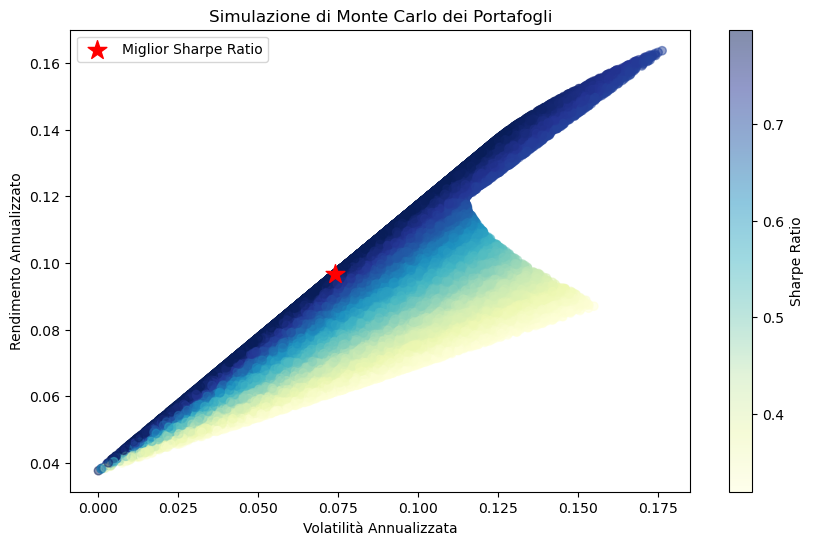

In [10]:
# Setting massimo rischio
max_risk_setting = 0.08 #<-------------------------------------------------------------------------------------

# Funzione per trovare il miglior portafoglio dato un rischio massimo
def find_best_portfolio_given_max_risk(results, df_max_vol, max_risk):
    dfSR1 =  df_max_vol.drop(columns=['MARKET_INDEX', 'Portfolio_Returns'])
    # Identifica il portafoglio ottimale dato un rischio massimo
    max_sharpe_idx_within_risk = np.where(results[:, 1] <= max_risk)[0]
    max_sharpe_idx_within_risk = max_sharpe_idx_within_risk[np.argmax(results[max_sharpe_idx_within_risk, 2])]
    max_sharpe_return_within_risk, max_sharpe_volatility_within_risk, max_sharpe_ratio_within_risk, max_sharpe_var_within_risk, max_sharpe_es_within_risk= results[max_sharpe_idx_within_risk][:5]
    max_sharpe_weights_within_risk = weights_record[max_sharpe_idx_within_risk]

    # Calcolo dei rendimenti del portafoglio con il miglior Sharpe Ratio
    df_max_vol['Portfolio_Returns_mv'] = dfSR1.dot(max_sharpe_weights_within_risk)

    # Determinazione del beta del portafoglio
    X = sm.add_constant(df_max_vol['MARKET_INDEX'])
    y = df_max_vol['Portfolio_Returns_mv']
    model = sm.OLS(y, X).fit()
    portfolio_beta = model.params['MARKET_INDEX']
    portfolio_alpha = model.params['const']

    return max_sharpe_var_within_risk, max_sharpe_es_within_risk, portfolio_alpha, portfolio_beta, max_sharpe_return_within_risk, max_sharpe_volatility_within_risk, max_sharpe_ratio_within_risk, max_sharpe_weights_within_risk

# Utilizzo della funzione per trovare il miglior portafoglio dato un rischio 
max_risk = max_risk_setting
max_sharpe_var_within_risk, max_sharpe_es_within_risk, alphacapm, beta, best_return, best_volatility, best_sharpe_ratio, best_weights = find_best_portfolio_given_max_risk(results, df_max_vol, max_risk)


# Output dei risultati
print(f"Miglior portafoglio dato un rischio massimo del {max_risk}:")
print(f"Rapporto di Sharpe: {best_sharpe_ratio:.4f}")
print(f"Rendimento annuale del portafoglio: {best_return:.6f}")
print(f"Volatilità annuale del portafoglio: {best_volatility:.4f}")
print(f"VaR annuale a {alpha*100}%: {max_sharpe_var_within_risk:.4f}")
print(f"Expected Shortfall annuale a {alpha*100}%: {max_sharpe_es_within_risk:.4f}")
print("------------------------------------------------------")
print(f"Pesi del portafoglio:")
for i in range(len(dfSR.columns)):
    print(f"{dfSR.columns[i]} : {int(best_weights[i]*10000)/100}%")
print("------------------------------------------------------")
print(f"Beta: {beta:.4f}")
print(f"Alpha: {int(alphacapm*trading_days*10000)/100}%")

# Grafico dei risultati
plt.figure(figsize=(10, 6))
plt.scatter(results[:, 1], results[:, 0], c=results[:, 2], cmap='YlGnBu', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilità Annualizzata')
plt.ylabel('Rendimento Annualizzato')
plt.title('Simulazione di Monte Carlo dei Portafogli')

# Evidenzia il portafoglio con il massimo Sharpe Ratio
plt.scatter(best_volatility, best_return, color='red', marker='*', s=200, label='Miglior Sharpe Ratio')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Rendimenti del portafoglio')

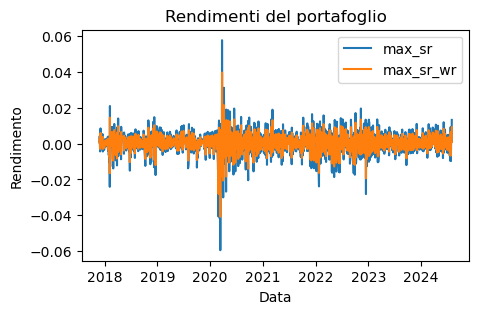

In [11]:
# Grafico andamento del portafoglio
plt.figure(figsize=(5, 3))
plt.plot(df.index, df['Portfolio_Returns'], label = 'max_sr')
plt.plot(df_max_vol.index, df_max_vol['Portfolio_Returns_mv'], label = 'max_sr_wr')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Rendimento')
plt.title('Rendimenti del portafoglio')


In [12]:
data_norm = data_norm.drop(columns=['Risk-Free'])
ret_port_norm_max_risk = data_norm.dot(best_weights)
ret_port_norm = data_norm.dot(max_sharpe_weights)

Text(0.5, 1.0, 'Rendimenti del portafoglio')

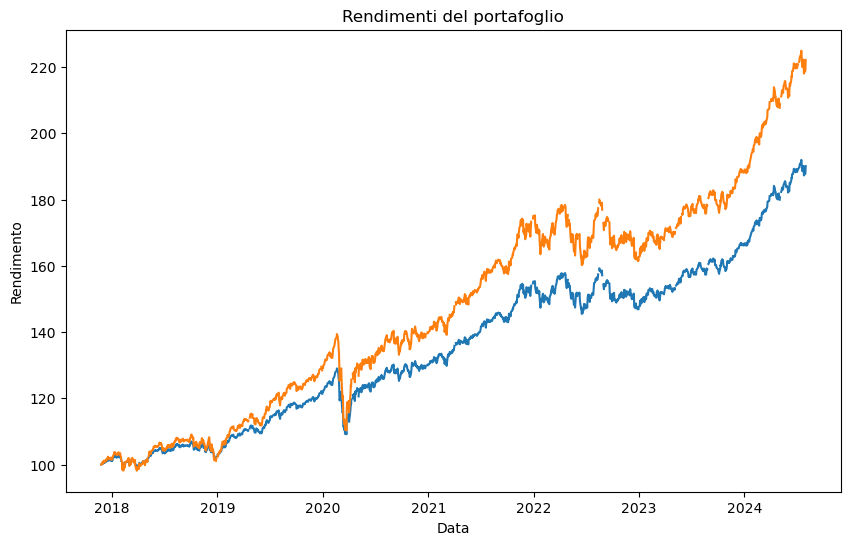

In [13]:

plt.figure(figsize=(10, 6))
plt.plot(data_norm.index, ret_port_norm_max_risk, label='Miglior Sharpe Ratio Max Risk')
plt.plot(data_norm.index, ret_port_norm, label='Miglior Sharpe Ratio')
plt.xlabel('Data')
plt.ylabel('Rendimento')
plt.title('Rendimenti del portafoglio')

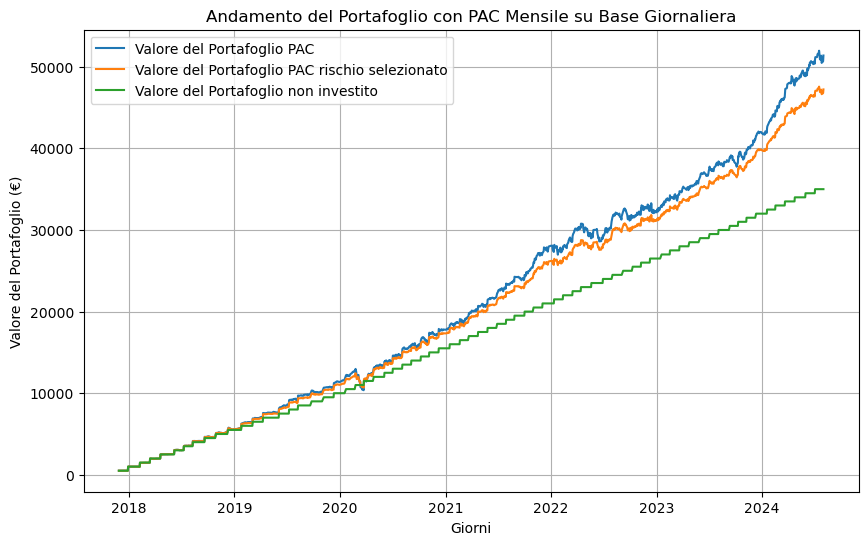

In [14]:
rendimenti = df['Portfolio_Returns']
rendimenti_wr = df_max_vol['Portfolio_Returns_mv']

# Parametri del PAC
investimento_mensile = 500  # euro investiti ogni mese
capitale_totale = 0
valore_portafoglio = 0
saldo = 0
valori_portafoglio = []  # Lista per tracciare l'andamento del portafoglio
no_inv = []

# Simulazione del PAC su base giornaliera
giorni_per_mese = 21  # Approssimazione dei giorni lavorativi in un mese
giorno_corrente = 0  # Traccia del giorno attuale

# Ciclo per simulare l'investimento mensile e l'applicazione dei rendimenti giornalieri
for i, rendimento in enumerate(rendimenti):
    if giorno_corrente == 0:
        valore_portafoglio += investimento_mensile  # Investimento mensile all'inizio del mese
        saldo += investimento_mensile
        
    # Applicazione del rendimento giornaliero
    valore_portafoglio *= (1 + rendimento)
    
    # Aggiungiamo il valore del portafoglio corrente alla lista
    valori_portafoglio.append(valore_portafoglio)
    no_inv.append(saldo)
    
    # Incrementa il giorno corrente
    giorno_corrente += 1
    
    # Resetta il conteggio del mese dopo aver simulato 21 giorni
    if giorno_corrente >= giorni_per_mese:
        giorno_corrente = 0

   
#________________________________________________
capitale_totale = 0
valore_portafoglio = 0
giorno_corrente = 0  
valori_portafoglio_wr = [] 

# Ciclo per simulare l'investimento mensile e l'applicazione dei rendimenti giornalieri
for i, rendimento in enumerate(rendimenti_wr):
    if giorno_corrente == 0:
        valore_portafoglio += investimento_mensile  # Investimento mensile all'inizio del mese

    # Applicazione del rendimento giornaliero
    valore_portafoglio *= (1 + rendimento)
    
    # Aggiungiamo il valore del portafoglio corrente alla lista
    valori_portafoglio_wr.append(valore_portafoglio)
    
    # Incrementa il giorno corrente
    giorno_corrente += 1
    
    # Resetta il conteggio del mese dopo aver simulato 21 giorni
    if giorno_corrente >= giorni_per_mese:
        giorno_corrente = 0

# Grafico dell'andamento del portafoglio
plt.figure(figsize=(10, 6))
plt.plot(df.index, valori_portafoglio, label='Valore del Portafoglio PAC')
plt.plot(df.index, valori_portafoglio_wr, label='Valore del Portafoglio PAC rischio selezionato')
plt.plot(df.index, no_inv, label='Valore del Portafoglio non investito')
plt.title('Andamento del Portafoglio con PAC Mensile su Base Giornaliera')
plt.xlabel('Giorni')
plt.ylabel('Valore del Portafoglio (€)')
plt.legend()
plt.grid(True)
plt.show()





Valore finale stimato del portafoglio: 66975.50€
Valore finale stimato del portafoglio: 60196.83€


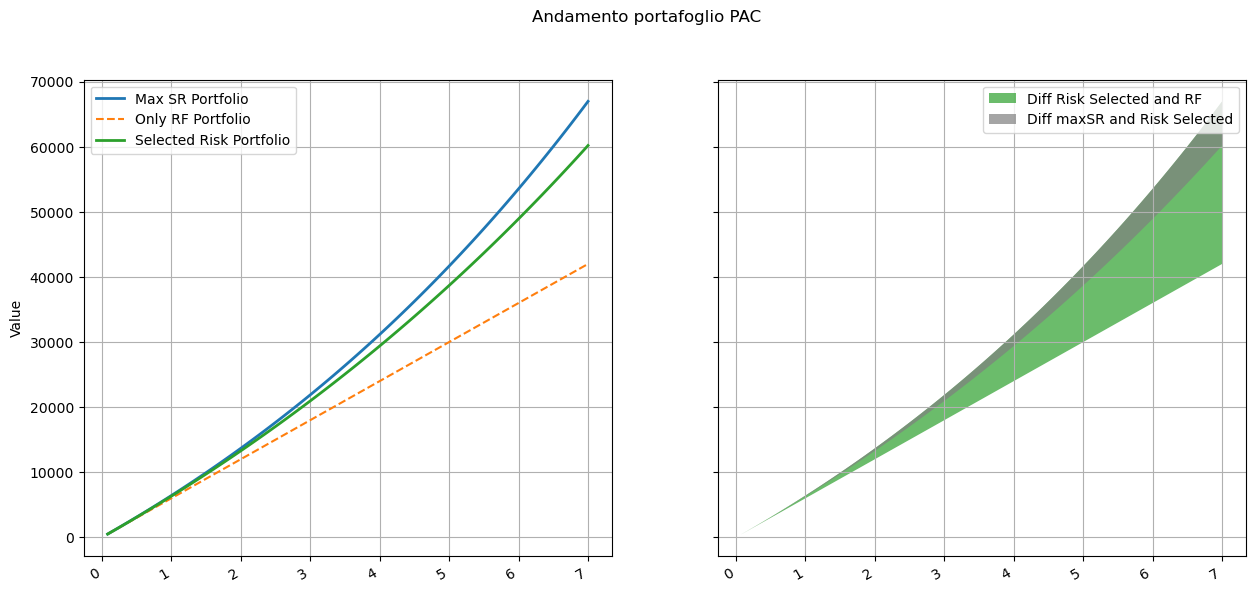

In [15]:
# Simulazione PAC
m_saving = 500 #Risparmio mensile investito
t_orizon_y = 7
t_orizon_m = t_orizon_y*12

tot = 0
and_maxsr = np.zeros((t_orizon_m, 3))

tot1 = 0
and_rc = np.zeros((t_orizon_m, 3))

for i in range(1,t_orizon_m+1):
    ret = (1 + (max_sharpe_return/12))** (i)
    tot = (m_saving*ret) + tot
    and_maxsr[i-1,0] = tot
    and_maxsr[ i-1,1] = (i)/12
    and_maxsr[ i-1,2] = m_saving * i
    
    ret1 = (1 + (best_return/12))** (i)
    tot1 = (m_saving*ret1) + tot1
    and_rc[i-1,0] = tot1
    and_rc[ i-1,1] = (i)/12
    and_rc[ i-1,2] = m_saving * i
    
print(f'Valore finale stimato del portafoglio: {tot:.2f}€')  
print(f'Valore finale stimato del portafoglio: {tot1:.2f}€')

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize= (15,7))

ax1.plot(and_maxsr[:,1], and_maxsr[:,0], lw=2, label= 'Max SR Portfolio') 
ax1.plot(and_maxsr[:,1], and_maxsr[:,2], ls='--',  label= 'Only RF Portfolio' )
ax1.plot(and_rc[:,1], and_rc[:,0], lw=2,  label= 'Selected Risk Portfolio' )
ax2.fill_between(and_maxsr[:,1], and_maxsr[:,0], and_maxsr[:,2],facecolor='C2', alpha=0.7, label= 'Diff Risk Selected and RF' )
ax2.fill_between(and_maxsr[:,1], and_maxsr[:,0], and_rc[:,0],facecolor='C7', alpha=0.7, label= 'Diff maxSR and Risk Selected' )

for ax in ax1, ax2:
    ax.grid(True)
    ax.label_outer()
    ax.legend(loc= 0)
              
ax1.set_ylabel('Value')

fig.suptitle('Andamento portafoglio PAC')
fig.autofmt_xdate()

